In [1]:
%pylab --no-import-all
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.utils.data_utils import get_file
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
import common as localUtils

from importlib import reload
reload(localUtils)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


<module 'common' from '/home/arthur/kaggle/mine/DSB3Tutorial/model/common.py'>

In [2]:
images_path = '/data1/cancer/KAG2017/stage1_scaled/64'
tSet = localUtils.TrainSet(images_path)

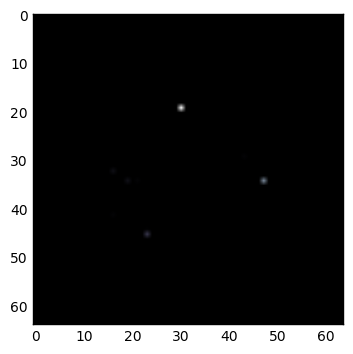

In [3]:
recoverimage = tSet.X_train[0]
pylab.imshow(recoverimage[32], cmap=pylab.cm.bone)
pylab.show()

In [4]:
class Vg3():
    """The Vg3 16 Imagenet model"""

    def __init__(self,shape,comment="here we go"):
        self.create(shape)
        self.meta = {"shape":str(shape),comment:comment}
   

    def predict(self, imgs, details=False):
        all_preds = self.model.predict(imgs)
        idxs = np.argmax(all_preds, axis=1)
        return np.array(preds), idxs
    
    def model_preprocess(self, x):
        return x

    def ConvBlock(self, layers, filters):
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))


    def Conv3DBlock(self, layers, filters):
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding3D((1, 1,1)))
            model.add(Convolution3D(filters, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'))
        model.add(MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'))
        
    def FCBlock(self):
        model = self.model
        model.add(Dense(4096, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


    def create(self, shape):

        model = self.model = Sequential()
        model.add(ZeroPadding3D((1, 1,1),input_shape=shape))
        self.Conv3DBlock(2, 4)
        self.Conv3DBlock(1, 8)
        self.Conv3DBlock(2,32)
        
        #self.Conv3DBlock(5, 16)
        self.Conv3DBlock(3, 32)
        #self.ConvBlock(2, 128)
        #self.ConvBlock(3, 256)
        #self.ConvBlock(3, 512)
        #self.ConvBlock(3, 512)

        model.add(Flatten())
        #model.add(Dense(64, activation='relu'))
        #model.add(BatchNormalization())
        self.FCBlock()
        #model.add(BatchNormalization())
        #self.FCBlock()
        model.add(Dense(1, init='normal', activation='sigmoid'))


    def fit(self, batches, val_batches, nb_epoch=1):
        self.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)


    def test(self, path, batch_size=8):
        test_batches = self.get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)
        return test_batches, self.model.predict_generator(test_batches, test_batches.nb_sample)


In [5]:
print(tSet.X_train3d[0].shape)
vg =  Vg3(tSet.trainX()[0].shape,"Trying with fc")
vg.model.summary()

(1, 64, 64, 64)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding3d_1 (ZeroPadding3D)  (None, 1, 66, 66, 66) 0           zeropadding3d_input_1[0][0]      
____________________________________________________________________________________________________
zeropadding3d_2 (ZeroPadding3D)  (None, 1, 68, 68, 68) 0           zeropadding3d_1[0][0]            
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 4, 68, 68, 68) 112         zeropadding3d_2[0][0]            
____________________________________________________________________________________________________
zeropadding3d_3 (ZeroPadding3D)  (None, 4, 70, 70, 70) 0           convolution3d_1[0][0]            
___________________________________________________________________________

In [6]:
vg.model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Train on 841 samples, validate on 94 samples
Epoch 1/5
841/841 [==============================] - 38s - loss: 0.5907 - acc: 0.7265 - val_loss: 3.4294 - val_acc: 0.7872
Epoch 2/5
841/841 [==============================] - 37s - loss: 0.5823 - acc: 0.7348 - val_loss: 3.4294 - val_acc: 0.7872
Epoch 3/5
841/841 [==============================] - 37s - loss: 0.5798 - acc: 0.7348 - val_loss: 3.4294 - val_acc: 0.7872
Epoch 4/5
841/841 [==============================] - 37s - loss: 0.5806 - acc: 0.7348 - val_loss: 3.4294 - val_acc: 0.7872
Epoch 5/5
841/841 [==============================] - 37s - loss: 0.5799 - acc: 0.7348 - val_loss: 3.4294 - val_acc: 0.7872
we have accuracy 0.742424242424
Confusion matrix, without normalization
[[343   0]
 [119   0]]
we have accuracy 0.740106951872
Confusion matrix, without normalization
[[692   0]
 [243   0]]


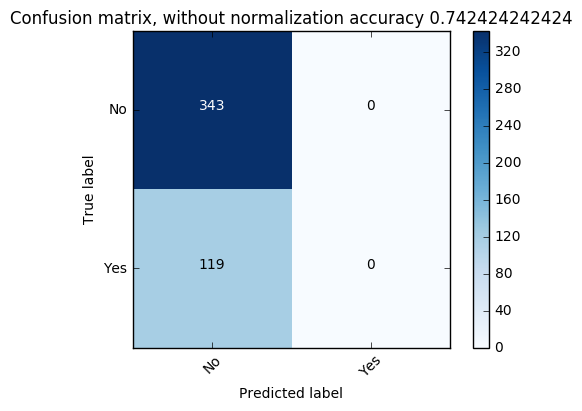

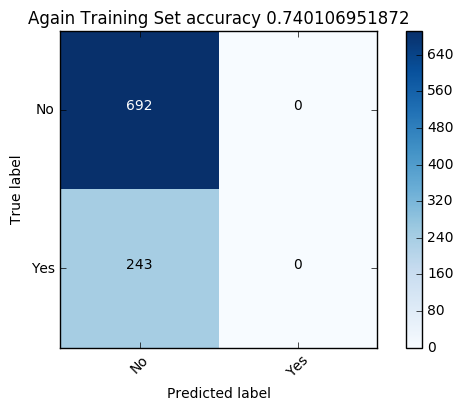

In [7]:
localUtils.evaluate(vg,tSet,"basic3d",nb_epoch=5)
plt.show()